In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

from model import BiSeNet

In [3]:
model = BiSeNet(n_classes=19)
model.load_state_dict(torch.load("checkpoints/79999_iter.pth", map_location=torch.device('cpu')))
model.eval();

In [4]:
def parse(img):
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    l = 512
    with torch.no_grad():
        img = img.resize((l,l), Image.BILINEAR)
        inp = to_tensor(img)
        out = model(torch.unsqueeze(inp, 0))[0]
        out = out.squeeze(0).cpu().numpy().argmax(0)
    return np.array(img), out

In [6]:
def calc_shift(m0, m1):
    mu = cv2.moments(m0, True)
    x0, y0 = int(mu["m01"]/mu["m00"]), int(mu["m10"]/mu["m00"])

    mu = cv2.moments(m1, True)
    x1, y1 = int(mu["m01"]/mu["m00"]), int(mu["m10"]/mu["m00"])
    return (x0-x1, y0-y1)

In [68]:
def swap_parts(i0, i1, m0, m1, labels):
    m0 = create_mask(m0, labels)
    m1 = create_mask(m1, labels)
    i,j = calc_shift(m0, m1)
    l = i0.shape[0]
    h0 = i0 * m0.reshape((l,l,1)) # forground
    y = np.zeros((l,l,3))
    if i>=0 and j>= 0:
        y[:l-i, :l-j] += h0[i:, j:]
    elif i>=0 and j<0:
        y[:l-i, -j:] += h0[i:, :l+j]
    elif i<0 and j>=0:
        y[-i:, :l-j] += h0[:l+i, j:]
    else:
        y[-i:, -j:] += h0[:l+i, :l+j]

    h1 = i1 * (1-m1).reshape((l,l,1)) # background
    b = cv2.morphologyEx(m1.astype('uint8'), cv2.MORPH_GRADIENT, np.ones((5,5)).astype('uint8') )
    c = (np.sum(i1*b.reshape((l,l,1)), axis=(0,1)) / np.sum(b)).astype(int)
    # fill color in the hole
    h1 += c * m1.reshape((l,l,1)) 
    y += h1 * (y==0)

    return y

In [18]:
def create_mask(m, labels):
    mask = np.zeros_like(m)
    for label in labels:
        mask += (m == label)
    mask = (mask>0).astype(int)
    return mask

In [19]:
def swap(i0, i1):
    # left eyebrow, right eybrow, left eye, right eye, nose, mouth
    parts = [[2], [3], [4], [5], [10], [11,12,13]]
    i0, m0 = parse(i0)
    i1, m1 = parse(i1)
    for part in parts:
        i1 = swap_parts(i0, i1, m0, m1, part)
    return i1

In [75]:
def concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

CPU times: user 2.81 s, sys: 567 ms, total: 3.38 s
Wall time: 3.23 s


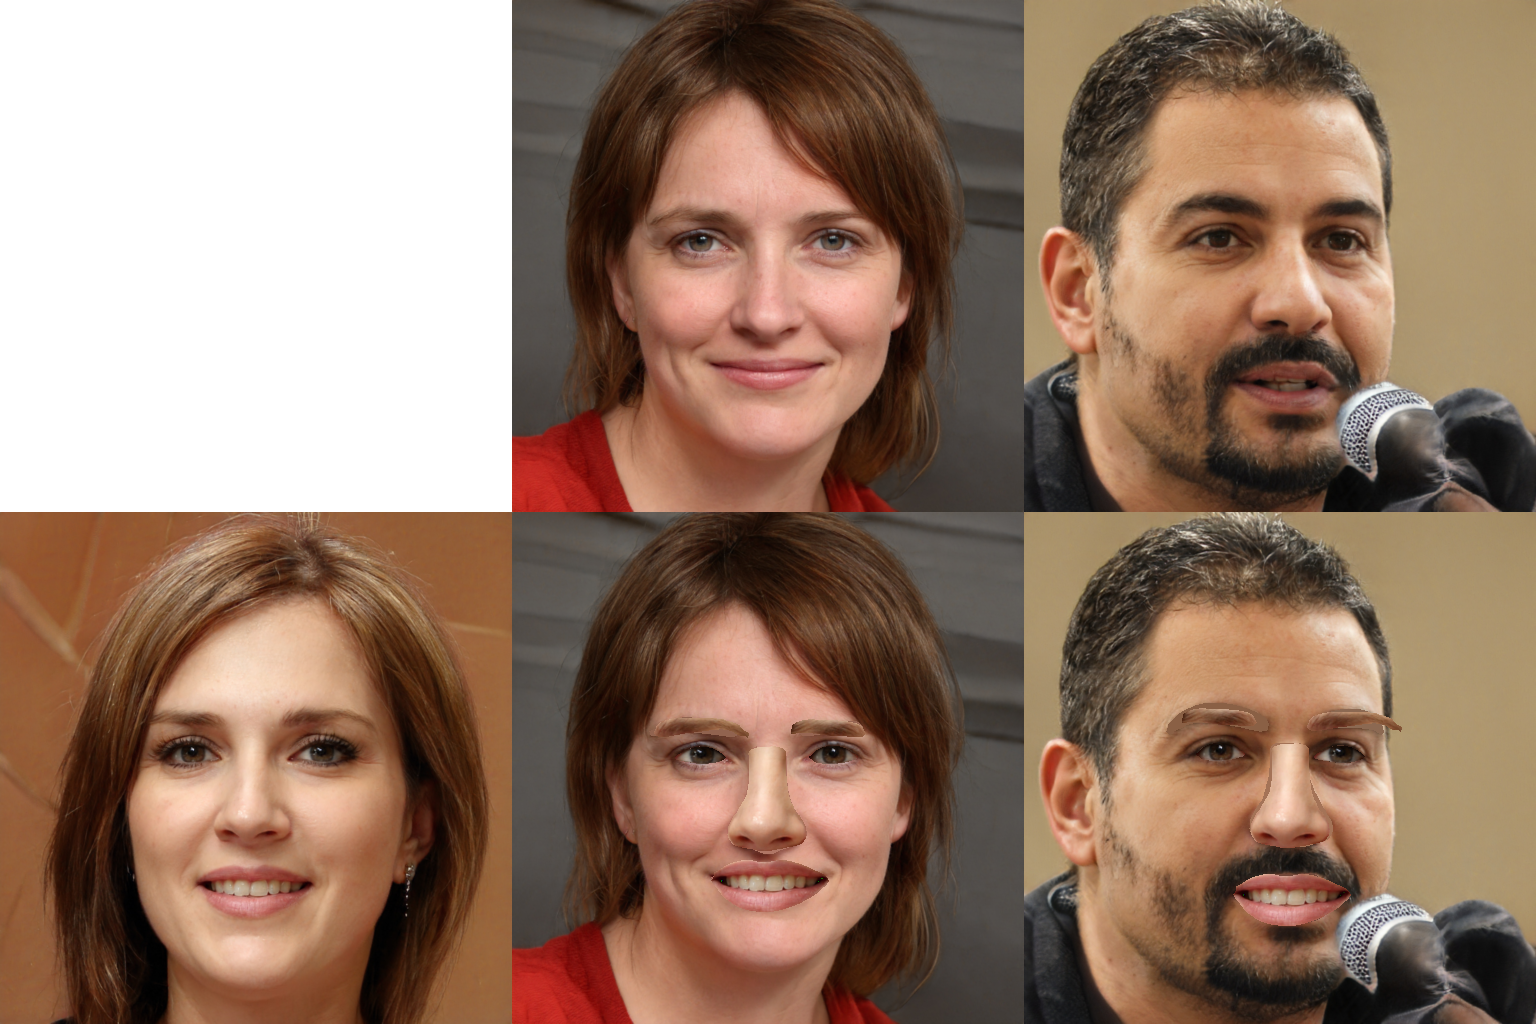

In [83]:
%%time
img0 = Image.open("photos/1.jpg").resize((512,512), Image.BILINEAR)
img1 = Image.open("photos/0.jpg").resize((512,512), Image.BILINEAR)
img2 = Image.open("photos/2.jpg").resize((512,512), Image.BILINEAR)
out1 = Image.fromarray(swap(img0, img1).astype('uint8'))
out2 = Image.fromarray(swap(img0, img2).astype('uint8'))


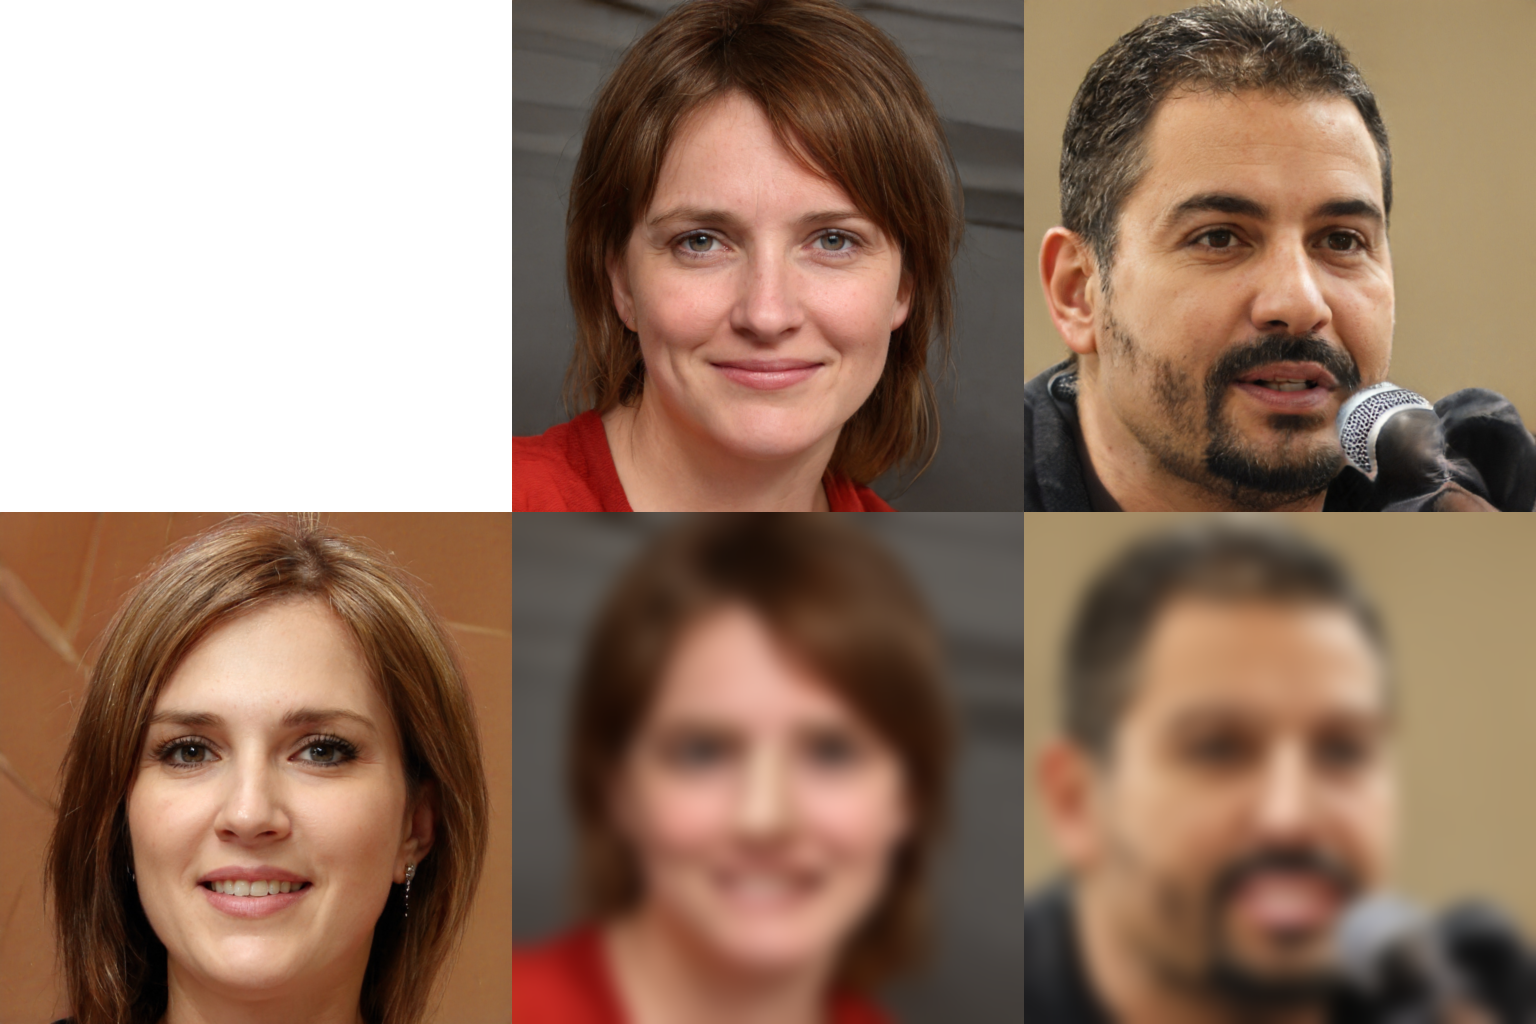

In [86]:
from PIL import ImageFilter
upper = concat_h(Image.fromarray(np.ones((512,512), np.uint8)*255), concat_h(img1, img2))
lower = concat_h(img0, concat_h(out1.filter(ImageFilter.GaussianBlur(10)), out2.filter(ImageFilter.GaussianBlur(10))))
res = concat_v(upper, lower)
res